# 2. Topic Modeling - Latent Dirchlet Allocation (LDA) + time dimension

In [1]:
# format code
# pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import re
import scipy.sparse
import gensim
import matplotlib.pyplot as plt
from lib.nlp_yt import sw
from gensim.corpora import Dictionary
from gensim import matutils
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer

<IPython.core.display.Javascript object>

### comment condition:  >15words AND 10 unique words

In [3]:
sw = sw.get_stop_words()

<IPython.core.display.Javascript object>

In [4]:
corpora_names = [
    "2019-05",
    "2019-06",
    "2019-07",
    "2019-08",
    "2019-09",
    "2019-10",
    "2019-11",
    "2019-12",
    "2020-01",
    "2020-02",
    "2020-03",
    "2020-04",
    "2020-05",
    "2020-06",
    "2020-07",
    "2020-08",
    "2020-09",
    "2020-10",
    "2020-11",
    "2020-12",
    "2021-01",
    "2021-02",
    "2021-03",
    "2021-04",
    "2021-05",
    "2021-06",
    "2021-07",
    "2021-08",
]

<IPython.core.display.Javascript object>

In [5]:
corpus = pd.read_pickle("data/pickle/corpus_tm_clean_df.pkl")
corpus

,comment,month
0,feier sowas endlich jemand alten cdu stimme ni...,2019-05
1,achtung faschisten irma lo beleidigt user ganz...,2021-06
2,zeigt jahre jahre,2019-05
3,doppelmoralist rezo eigenes video dezember pri...,2021-05
4,richtig,2019-05
...,...,...
229508,legalisierung mehr fahrverbote läuft,2019-05
229509,j pepe leg fakten falsche informationen rausha...,2019-05
229510,bundestag stehen abgeordnete mandat halten unt...,2019-05
229511,liebe user lasst daran hindern frei meinung ek...,2021-07


<IPython.core.display.Javascript object>

In [9]:
corpus_d = {}
for month in corpora_names:
    corpus_d[month] = {
        "len": len(corpus.loc[corpus["month"] == month]),
        "corpora": pd.DataFrame(
            pd.DataFrame(corpus.loc[corpus["month"] == month])["comment"]
        ),
    }


corpora_info = []

for key, value in corpus_d.items():
    corpora_info.append((key, value["len"]))

corpora_docs = [x[1] for x in corpora_info]
corpora_docs_sum = sum(corpora_docs)

print(corpora_info)

[('2019-05', 131867), ('2019-06', 14783), ('2019-07', 2653), ('2019-08', 2376), ('2019-09', 1861), ('2019-10', 1163), ('2019-11', 1290), ('2019-12', 1375), ('2020-01', 1069), ('2020-02', 1125), ('2020-03', 1052), ('2020-04', 1555), ('2020-05', 1388), ('2020-06', 1862), ('2020-07', 1712), ('2020-08', 2111), ('2020-09', 1834), ('2020-10', 1975), ('2020-11', 2139), ('2020-12', 1519), ('2021-01', 3090), ('2021-02', 8073), ('2021-03', 9055), ('2021-04', 11326), ('2021-05', 6829), ('2021-06', 3294), ('2021-07', 9413), ('2021-08', 1724)]


<IPython.core.display.Javascript object>

In [10]:
MIN_WORDS = 15
MIN_UNIQUE_WORDS = 10
progress = 0
print("")

for key, value in corpus_d.items():
    value["texts"] = []
    doc_to_drop = []

    for i in list(value["corpora"].index):
        progress += 1
        if len(value["corpora"].loc[i].comment.split()) < MIN_WORDS:
            doc_to_drop.append(i)
        elif len(set(value["corpora"].loc[i].comment.split())) < MIN_UNIQUE_WORDS:
            doc_to_drop.append(i)
        else:
            # (list of list of str) Tokenized texts, needed for coherence models
            value["texts"].append(value["corpora"].loc[i].comment.split())

        if progress % 100 == 0:
            print(f"progress: {progress}/{corpora_docs_sum}", end="\r")

    value["corpora"] = value["corpora"].drop(index=doc_to_drop)

    d_ = {}
    for i, v in enumerate(list(value["corpora"].index)):
        d_[v] = i
    value["corpora"] = value["corpora"].rename(index=d_)

print("")


progress: 229500/229513


<IPython.core.display.Javascript object>

In [11]:
corpora_filtered_info = [
    (key, len(value["corpora"].index)) for key, value in corpus_d.items()
]
print(corpora_filtered_info)

[('2019-05', 44297), ('2019-06', 6017), ('2019-07', 1062), ('2019-08', 943), ('2019-09', 640), ('2019-10', 410), ('2019-11', 510), ('2019-12', 454), ('2020-01', 339), ('2020-02', 357), ('2020-03', 255), ('2020-04', 407), ('2020-05', 387), ('2020-06', 510), ('2020-07', 417), ('2020-08', 544), ('2020-09', 319), ('2020-10', 376), ('2020-11', 382), ('2020-12', 267), ('2021-01', 678), ('2021-02', 2213), ('2021-03', 3863), ('2021-04', 6113), ('2021-05', 3656), ('2021-06', 1129), ('2021-07', 4500), ('2021-08', 852)]


<IPython.core.display.Javascript object>

In [13]:
docs_post_filtering = [x[1] for x in corpora_filtered_info]
print(f" docs per month (post filtering):\n {docs_post_filtering}")
print(f"\n nr docs (post filtering): {sum(docs_post_filtering)}")

 docs per month (post filtering):
 [44297, 6017, 1062, 943, 640, 410, 510, 454, 339, 357, 255, 407, 387, 510, 417, 544, 319, 376, 382, 267, 678, 2213, 3863, 6113, 3656, 1129, 4500, 852]

 nr docs (post filtering): 81897


<IPython.core.display.Javascript object>

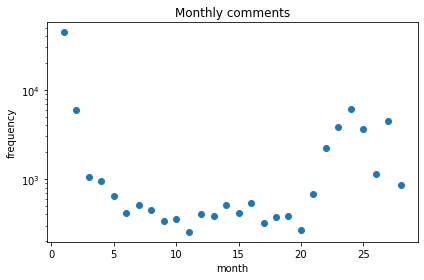

<IPython.core.display.Javascript object>

In [14]:
# scatterplot months
plt.scatter(range(1, len(docs_post_filtering) + 1), docs_post_filtering)
plt.title("Monthly comments")
plt.xlabel("month")
plt.ylabel("frequency")
plt.yscale("log")

plt.savefig("data/pdf/scatter_comments_post_filtering_tm_log.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [15]:
corpora_filtered_percentage = [
    (x[0][0], (round(1 - (x[0][1] / x[1][1]), 2)))
    for x in list(zip(corpora_filtered_info, corpora_info))
]
corpora_filtered_percentage

[('2019-05', 0.66),
 ('2019-06', 0.59),
 ('2019-07', 0.6),
 ('2019-08', 0.6),
 ('2019-09', 0.66),
 ('2019-10', 0.65),
 ('2019-11', 0.6),
 ('2019-12', 0.67),
 ('2020-01', 0.68),
 ('2020-02', 0.68),
 ('2020-03', 0.76),
 ('2020-04', 0.74),
 ('2020-05', 0.72),
 ('2020-06', 0.73),
 ('2020-07', 0.76),
 ('2020-08', 0.74),
 ('2020-09', 0.83),
 ('2020-10', 0.81),
 ('2020-11', 0.82),
 ('2020-12', 0.82),
 ('2021-01', 0.78),
 ('2021-02', 0.73),
 ('2021-03', 0.57),
 ('2021-04', 0.46),
 ('2021-05', 0.46),
 ('2021-06', 0.66),
 ('2021-07', 0.52),
 ('2021-08', 0.51)]

<IPython.core.display.Javascript object>

In [16]:
corpora_filtered_documents_f = [x[1] for x in corpora_filtered_info]
corpora_filtered_documents_sum = sum(corpora_filtered_documents_f)
corpora_filtered_documents_min = min(corpora_filtered_documents_f)
corpora_filtered_documents_max = max(corpora_filtered_documents_f)
corpora_filtered_documents_mean = np.mean(corpora_filtered_documents_f)
corpora_filtered_documents_median = np.median(corpora_filtered_documents_f)
print(f"sum docs: {corpora_filtered_documents_sum}")
print("")
print(f"min docs: {corpora_filtered_documents_min}")
print(f"max docs: {corpora_filtered_documents_max}")
print("")
print(f"mean docs: {corpora_filtered_documents_mean}")
print(f"median docs: {corpora_filtered_documents_median}")

sum docs: 81897

min docs: 255
max docs: 44297

mean docs: 2924.8928571428573
median docs: 527.0


<IPython.core.display.Javascript object>

In [17]:
for key, value in corpus_d.items():
    value["tfidf_vectorizer"] = TfidfVectorizer(stop_words=sw)
    value["tfidf_wm"] = value["tfidf_vectorizer"].fit_transform(
        value["corpora"].comment
    )
    value["tfidf"] = pd.DataFrame(
        value["tfidf_wm"].toarray(),
        columns=value["tfidf_vectorizer"].get_feature_names(),
    )
    value["tfidf"].index = value["corpora"].index
    value["tfidf"] = value["tfidf"].transpose()

<IPython.core.display.Javascript object>

In [18]:
for key, value in corpus_d.items():
    value["dictionary"] = Dictionary(value["texts"])
    value["sparse_counts"] = scipy.sparse.csr_matrix(value["tfidf"])
    value["corpus_sparse"] = matutils.Sparse2Corpus(value["sparse_counts"])
    value["id2word"] = dict(
        (v, k) for k, v in value["tfidf_vectorizer"].vocabulary_.items()
    )

<IPython.core.display.Javascript object>

###  evaluate number of topics for each month

In [19]:
start = 8
limit = 20
step = 1
print("")

for key, value in corpus_d.items():
    value["lda_models"] = []
    print(f"processing: {key}", end="\r")

    for num_topics in range(start, limit, step):
        # list of tuple of model,coherence
        lda_model = models.LdaModel(
            corpus=value["corpus_sparse"],
            id2word=value["id2word"],
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            passes=10,
            alpha="auto",
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=value["texts"],
            dictionary=value["dictionary"],
        )
        value["lda_models"].append((lda_model, coherence_model.get_coherence()))

print("")


processing: 2021-08


<IPython.core.display.Javascript object>

In [20]:
for key, value in corpus_d.items():
    print(f"## {key}")
    lda_coherence_values = [x[1] for x in value["lda_models"]]
    num_topics_lda = list(range(start, limit, step))

    assert len(num_topics_lda) == len(lda_coherence_values)

    print(list(zip([str(x) + " Topics" for x in num_topics_lda], lda_coherence_values)))
    print("\n\n")

## 2019-05
[('8 Topics', 0.7661385957563174), ('9 Topics', 0.7679247736753027), ('10 Topics', 0.7691512391843465), ('11 Topics', 0.7576900444582629), ('12 Topics', 0.7593173882828665), ('13 Topics', 0.7451735312228991), ('14 Topics', 0.7433243045376897), ('15 Topics', 0.7416149272821325), ('16 Topics', 0.738729469548445), ('17 Topics', 0.7451501531289364), ('18 Topics', 0.7427174556703858), ('19 Topics', 0.7369706831784278)]



## 2019-06
[('8 Topics', 0.7666136897006809), ('9 Topics', 0.7665050557446026), ('10 Topics', 0.7658759054253722), ('11 Topics', 0.7681634728666225), ('12 Topics', 0.7513391028642157), ('13 Topics', 0.7585636821327071), ('14 Topics', 0.7529317910472043), ('15 Topics', 0.7560232383492386), ('16 Topics', 0.7546647270312176), ('17 Topics', 0.7562886465811297), ('18 Topics', 0.7548032918179557), ('19 Topics', 0.7571677752020233)]



## 2019-07
[('8 Topics', 0.7796527567667916), ('9 Topics', 0.7991458226972602), ('10 Topics', 0.7986626234238852), ('11 Topics', 0.7909

<IPython.core.display.Javascript object>

In [21]:
# get *best* 28 models
num_topics_max_coherence = []

for key, value in corpus_d.items():
    max_coherence = max([x[1] for x in value["lda_models"]])
    nr_topics = None
    for i, t in enumerate(value["lda_models"]):
        if t[1] == max_coherence:
            nr_topics = start + step * i
    num_topics_max_coherence.append((key, nr_topics, max_coherence))

assert len(num_topics_max_coherence) == 28
print(f"nr topics with max coherence per month: \n")
for t in num_topics_max_coherence:
    print(f"{t[0]}  %2s  {t[2]}" % t[1])

nr topics with max coherence per month: 

2019-05  10  0.7691512391843465
2019-06  11  0.7681634728666225
2019-07   9  0.7991458226972602
2019-08  10  0.7979312635883969
2019-09   8  0.7855600855552394
2019-10  17  0.7997466269921635
2019-11  11  0.7910496894283757
2019-12   8  0.7845931779013904
2020-01  10  0.8087258113767783
2020-02  13  0.7792897340982209
2020-03  18  0.7983983702213976
2020-04  11  0.8012790541635002
2020-05   9  0.8054927733179827
2020-06  19  0.7735206491220906
2020-07  15  0.7441341586439674
2020-08  18  0.7473548711941036
2020-09  16  0.7894345681923103
2020-10  17  0.7732285858135848
2020-11  14  0.7590408721110713
2020-12  15  0.7970147501238266
2021-01  11  0.7866501179770397
2021-02   9  0.7860255530087089
2021-03  11  0.7690804874888417
2021-04   8  0.7512298846248422
2021-05  17  0.7532198241619205
2021-06  12  0.7853578831440139
2021-07  11  0.7700381132203766
2021-08  12  0.7449877881574006


<IPython.core.display.Javascript object>

In [22]:
print(f"nr topics mean: {np.mean([x[1] for x in num_topics_max_coherence])}")
print(f"nr topics median: {np.median([x[1] for x in num_topics_max_coherence])}")

nr topics mean: 12.5
nr topics median: 11.0


<IPython.core.display.Javascript object>

### evaluate best equal number of topics

In [23]:
print(f"pre coherence mean: {np.mean([x[2] for x in num_topics_max_coherence])}")
print(f"pre coherence median: {np.median([x[2] for x in num_topics_max_coherence])}")

pre coherence mean: 0.7792444724419918
pre coherence median: 0.7849755305227022


<IPython.core.display.Javascript object>

In [24]:
d_lda_model_stats_equal_nr_topics = {}

for nr_topics_for_model in range(start, limit, step):
    topic_idx = int((nr_topics_for_model - start) / step)
    for i, (key, value) in enumerate(corpus_d.items()):
        if nr_topics_for_model not in d_lda_model_stats_equal_nr_topics:
            d_lda_model_stats_equal_nr_topics[nr_topics_for_model] = []
        d_lda_model_stats_equal_nr_topics[nr_topics_for_model].append(
            (
                key,
                nr_topics_for_model,
                value["lda_models"][topic_idx][1],
            )
        )
    assert len(d_lda_model_stats_equal_nr_topics[nr_topics_for_model]) == 28

num_topics_mean_coherence = []

for key, value in d_lda_model_stats_equal_nr_topics.items():
    coherence_values = [x[2] for x in value]
    num_topics_mean_coherence.append((key, np.mean(coherence_values)))

num_topics_mean_coherence.sort(key=lambda t: t[1], reverse=True)
print(num_topics_mean_coherence)

[(8, 0.7719218091224301), (9, 0.7712483297093223), (11, 0.7711606939496419), (16, 0.7694547643828307), (10, 0.7688960728550102), (13, 0.7688181546123897), (17, 0.7681046071514973), (15, 0.7678925365262131), (14, 0.7677739113178311), (12, 0.7677517128706492), (18, 0.7672809409429087), (19, 0.7651551057814723)]


<IPython.core.display.Javascript object>

In [25]:
# choose best coherence mean for equal number of topics
optimal_eq_num_topics = d_lda_model_stats_equal_nr_topics[
    num_topics_mean_coherence[0][0]
]

<IPython.core.display.Javascript object>

In [26]:
print(f"post coherence mean: {np.mean([x[2] for x in optimal_eq_num_topics])}")
print(f"post coherence median: {np.median([x[2] for x in optimal_eq_num_topics])}")

post coherence mean: 0.7719218091224301
post coherence median: 0.77420567822079


<IPython.core.display.Javascript object>

In [27]:
optimal_eq_num_topics

[('2019-05', 8, 0.7661385957563174),
 ('2019-06', 8, 0.7666136897006809),
 ('2019-07', 8, 0.7796527567667916),
 ('2019-08', 8, 0.7964136545083715),
 ('2019-09', 8, 0.7855600855552394),
 ('2019-10', 8, 0.7951510269320956),
 ('2019-11', 8, 0.7875186043468638),
 ('2019-12', 8, 0.7845931779013904),
 ('2020-01', 8, 0.7957372120954653),
 ('2020-02', 8, 0.7695463985445326),
 ('2020-03', 8, 0.7893439045792046),
 ('2020-04', 8, 0.795164250639016),
 ('2020-05', 8, 0.800013696463172),
 ('2020-06', 8, 0.765481448393396),
 ('2020-07', 8, 0.7323253491546089),
 ('2020-08', 8, 0.7385508393714753),
 ('2020-09', 8, 0.782297299241761),
 ('2020-10', 8, 0.7701851405026823),
 ('2020-11', 8, 0.7483020174554376),
 ('2020-12', 8, 0.7782262159388976),
 ('2021-01', 8, 0.7701136618404916),
 ('2021-02', 8, 0.7827816261960603),
 ('2021-03', 8, 0.7628495741586616),
 ('2021-04', 8, 0.7512298846248422),
 ('2021-05', 8, 0.7418548576094841),
 ('2021-06', 8, 0.7815697674141195),
 ('2021-07', 8, 0.7634669302308409),
 ('20

<IPython.core.display.Javascript object>

### inteprete: top 10 keywords -> topic

In [29]:
nr_words = 10


def get_topics_format(topics):
    topics_words = []
    for topic in topics:
        s = topic[1].split("+")
        s = [tuple(x.split("*")) for x in s]
        weights = [float(x[0]) for x in s]
        words = [x[1].replace('"', "") for x in s]
        topics_words.append(list(zip(words, weights)))
    return topics_words


for idx, (key, value) in enumerate(corpus_d.items()):
    nr_t = optimal_eq_num_topics[idx][1]
    lda_index = int((nr_t - start) / step)
    coherence_value = value["lda_models"][lda_index][1]
    print(f"## {key} | {nr_t} Topics | coherence {coherence_value}\n")

    weights = []

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        relative_weight = weights_mean * len(topic_words)
        weights.append(relative_weight)

    # normalize sum of relative weights to 1 (0.9999)
    assert len(weights) == nr_t
    weights_sum = sum(weights)
    weights = [round(x * (1 / weights_sum), 4) for x in weights]
    weights_sum = sum(weights)
    assert abs(1 - weights_sum) <= 0.001

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        print(
            f"### Topic: {i+1} | weights_mean: {round(weights_mean,4)} | relative weight: {weights[i]} | "
        )
        print(topic_words, "\n")

    print("\n\n")

## 2019-05 | 8 Topics | coherence 0.7661385957563174

### Topic: 1 | weights_mean: 0.0035 | relative weight: 0.0975 | 
[('idee ', 0.004), ('co² ', 0.004), ('böse ', 0.004), ('kritisieren ', 0.004), ('immerhin ', 0.004), ('unsinn ', 0.003), ('schlechter ', 0.003), ('mindestens ', 0.003), ('treibhauseffekt ', 0.003), ('verstehst', 0.003)] 

### Topic: 2 | weights_mean: 0.004 | relative weight: 0.1114 | 
[('deutschland ', 0.007), ('grünen ', 0.006), ('klimawandel ', 0.005), ('klima ', 0.004), ('wissenschaftler ', 0.003), ('usa ', 0.003), ('zb ', 0.003), ('geld ', 0.003), ('weniger ', 0.003), ('erde', 0.003)] 

### Topic: 3 | weights_mean: 0.0047 | relative weight: 0.1309 | 
[('warte ', 0.007), ('ersetzt ', 0.006), ('jugoslawien ', 0.005), ('besitzen ', 0.005), ('anführen ', 0.004), ('weswegen ', 0.004), ('überdenken ', 0.004), ('fotosynthese ', 0.004), ('koalieren ', 0.004), ('kleineren', 0.004)] 

### Topic: 4 | weights_mean: 0.0057 | relative weight: 0.1588 | 
[('wähl ', 0.009), ('belei

<IPython.core.display.Javascript object>